In [2]:
%reload_ext autotime
from helpers.common_imports import *
import helpers.utilities as ut
import joblib, zipcodes, sklearn, geopandas as gpd, seaborn as sns
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, RocCurveDisplay
sklearn.set_config(transform_output="pandas")

pd.options.display.max_rows = 4
pd.options.display.max_columns = None
def disp(df, k=100):
    pd.options.display.min_rows = 2*k
    pd.options.display.max_rows = 2*k
    display(df)
    pd.options.display.min_rows = 4
    pd.options.display.max_rows = 4

repl = {
    'newfirsttime':'ftic',
    'new first ti':'ftic',
    'transfer':'trf',
    'returning':'rtn',
    'readmit student, undergra':'readmit student',
    'deferred':pd.NA,
    'bacterial meningitis, bacterial meningitis':'bacterial meningitis',
    'bacm,  bacm':'bacm',
    'no housing application fee; no housing application fee':'no housing application fee',
    'medproctor complete, medproctor complete':'medproctor complete',
    '0000':'und',
}

def rnd(df, digits=0):
    df = pd.DataFrame(df).round(digits)
    if digits == 0:
        df = df.astype('Int64')
    return df.squeeze()

def encode(df, verbose=True, sep=', '):
    df = pd.DataFrame(df)
    idx = df.index.names
    def fcn(nm, X):
        return (X
                .str.split(sep, expand=True)
                .reset_index()
                .melt(id_vars=idx)
                .dropna(subset='value')
                .assign(value=lambda x: nm+':'+x['value'] if verbose else x['value'])
                .drop(columns='variable')
            )
    D = {nm: fcn(nm, X) for nm, X in df.select_dtypes(['string', 'object']).items()}
    print(D.keys())
    Y = (pd.concat(D.values(), axis=0)
         .drop_duplicates()
         .assign(dummy=True)
         .pivot_table(index=idx, columns='value', values='dummy')
         .rename_axis(columns=None)
         .astype('boolean')
         .fillna(False)
        )
    return df.drop(columns=D.keys()).join(Y).prep().squeeze()
pd.Series.prep = ut.prep
pd.DataFrame.prep = ut.prep
pd.Series.rnd = rnd
pd.DataFrame.rnd = rnd
pd.Series.encode = encode
pd.DataFrame.encode = encode



@dataclasses.dataclass
class EnrollmentPredictor(ut.MyBaseClass):
    flags_date  :str  ='2023-03-29'
    root_path   :str  ='/home/azureuser/cloudfiles/code/Users/scook/enrollment_predictor'
    attrs       :tuple=tuple()
    feats       :tuple=tuple()
    targs       :tuple=tuple()
    refresh     :tuple=tuple()
    report_performance :bool=True
    do_shap            :bool=False
    random_state       :int=42
    cv__folds          :int=5
    tune__n_iter       :int=10
    boot__n_samples     :int=1000
    impute__n_neighbors:int=15
    # shap__n_means      :int=10
    # shap__n_samples    :int=100
    test_size          :float=0.25

    def __post_init__(self):
        self.idx = ['id','term_code','student_type']
        self.dependencies = {
            'courses'    :{},
            'distances'  :{},
            'flags'      :{},
            'bunting'    :{'flags'},
            'final'      :{'bunting','courses','distances'},
            'multipliers':{'courses','final'},
            'F'          :{'final'},
            'X'          :{'F'},
            'X_imp'      :{},
            'y'          :{'F'},
            'model'      :{},
            'proba'      :{'X','model'},
            'samples'    :{'F','multipliers','proba'},
            # 'actuals'    :{'courses'},
            'predictions':{'course','samples'},
            'intervals'  :{'predictions'},
        }
        self.refresh = ut.setify(self.refresh)
        l = 0
        while l < len(self.refresh):
            l = len(self.refresh)
            for attr in self.refresh.copy():
                assert attr in self.dependencies.keys(), f'refresh contains {attr} ... must be {list(self.dependencies.keys())}'
                for key, val in self.dependencies.items():
                    if attr in val:
                        self.refresh.add(key)
            
        self.flags_date = datetime.datetime.fromisoformat(self.flags_date)
        self.file = dict()
        self.path = {'root':pathlib.Path(self.root_path)}
        self.path['xlsx'] = self.path['root'] / f'xlsx'
        self.path['parq'] = self.path['root'] / f'parq'
        self.path['modl'] = self.path['root'] / f'modl'
        self.path['shap'] = self.path['root'] / f'shap'
        del self.root_path
        for p in self.path.values():
            p.mkdir(exist_ok=True, parents=True)

    def fetch(self, var, fcn, file=None):
        if file is None:
            discard = True
            if var in ['courses','distances']:
                file = self.path['parq'] / f'{var}.parq'
            else:
                file = self.path['parq'] / f'{self.flags_date.date()}_{var}.parq'
        else:
            discard = False
        if var in self.refresh:
            file.unlink(missing_ok=True)
        try:
            obj = self[var]
        except:
            try:
                obj = pd.read_parquet(file).prep()
            except:
                try:
                    obj = joblib.load(file)
                except:
                    # for v in self.dependencies[var]:
                    #     try:
                    #         self['get_'+v]()
                    #     except:
                    #         pass
                    print('building', '/'.join(file.parts[-2:]))
                    obj = fcn()
                    if file.suffix == '.parq':
                        obj.prep().to_parquet(file)
                    else:
                        joblib.dump(obj, file)
        self[var] = obj
        self.file[var] = file
        if discard:
            self.refresh.discard(var)
        return obj

    def get_courses(self):
        var = 'courses'
        def fcn():
            src = self.path['xlsx'] / 'Fall_2017-2022_Courses_01-27-2023.xlsx'
            df = (pd.read_excel(src)
                  .prep()
                  .astype('string')
                  .rename(columns={'term':'term_code', 'levl':'level'})
                  .apply(lambda x:x.str.lower().str.replace(' ',''))
                  .replace(repl)
                  .set_index([*self.idx, 'level'])  # can drop level if desired
                  .encode(verbose=False)
                  .assign(yld=lambda x: x.any(axis=1))
                 )
            return df
        return self.fetch(var, fcn)

    def get_distances(self):
        var = 'distances'
        def fcn():
            Z = pd.DataFrame({z['zip_code']:[z['long'],z['lat']] for z in zipcodes.list_all()}).T.rename_axis(index=['zip']).prep()
            Z = gpd.GeoSeries(gpd.points_from_xy(Z[0], Z[1]), Z.index, crs='EPSG:4326').to_crs('ESRI:102005')
            df = (
                pd.DataFrame({
                    's':Z.distance(Z[76402]),
                    'm':Z.distance(Z[76036]),
                    'w':Z.distance(Z[76708]),
                    'r':Z.distance(Z[77807]),
                    'l':Z.distance(Z[76065]),
                })
                .div(1609.34)
                .melt(var_name='campus_code', value_name='distance', ignore_index=False)
                .set_index('campus_code', append=True)
            )
            return df
        return self.fetch(var, fcn)

    def get_bunting(self):
        var = 'bunting'
        def fcn():
            xlsx = dict()
            for yr in range(2021, 2024):
                targ = self.flags_date.replace(year=yr)
                best = 9999
                for file in self.path['xlsx'].iterdir():
                    try:
                        curr = datetime.datetime.fromisoformat(file.stem.lower().split('admitted')[0].replace('_', '-')[:-1])
                        diff = abs(curr - targ).days
                        if best > diff and diff < 14 and file.suffix.lower() == '.xlsx':
                            best = diff
                            xlsx[yr] = file
                    except ValueError:
                        pass
            col_repl = {
                'admt_code_descr.':'admt_code_descr',
                'ethnic_category':'hispanic',
                'tsi_hold_exists':'tsi_holds_exist',
            }
            L = []
            var_yr = 'flags'
            for yr, src_yr in xlsx.items():
                file_yr = self.path['parq'] / src_yr.with_suffix('.parq').name.lower()
                if var_yr in self:
                    del self[var_yr]
                def fcn_yr():
                    sheet = f'{yr}08'
                    df = pd.read_excel(src_yr, sheet_name=sheet).prep().astype('string').rename(columns=col_repl).assign(year=yr)
                    return df
                L.append(self.fetch(var_yr, fcn_yr, file_yr))
            
            def to_num(x, min_char=0, max_char=None):
                y = x.str.replace('[^$0-9.]', '', regex=True).str.replace('\.+', '.', regex=True).str[:max_char].fillna('')
                y[y.apply(len)<min_char] = pd.NA
                return y
            d = {
                'immu_date'      : lambda x:x.str.split(', ', expand=True)[0],
                'hs_pctl'        : lambda x:x.str.split(', ', expand=True)[0],
                'hispanic'       : lambda x:(x=='hispanic or latino').fillna(False),
                'hs_gpa'         : lambda x:to_num(x),
                'primary_phone'  : lambda x:to_num(x,10,10),
                'call_em_all'    : lambda x:to_num(x,10,10),
                'zip'            : lambda x:to_num(x,5,5),
            }
            with contextlib.redirect_stderr(open(os.devnull, 'w')):  # suppress some annoying and unneccessary warnings
                df = pd.concat(L, ignore_index=True).prep().astype('string').apply(lambda x:x.str.lower().str.strip()).replace(repl)
                for col, fcn in d.items():
                    df[col] = fcn(df[col])
                for col in ['decision_date','app_date','dob','eab_adv_column_update','hs_grad_date','immu_date','report_run_dte','ssb_last_accessed','u4_from_date','u7_from_date']:
                    df[col] = pd.to_datetime(df[col], errors='coerce')
                for col in ['reading', 'writing', 'math']:
                    df[col] = ~df[col].isin(['not college ready', 'retest required', pd.NA])
                for col in ['legacy', 'ssb_last_accessed']:
                    df[col] = df[col].notnull()
                for col, dt in df.dtypes.items():
                    if df[col].nunique() == 1 and not pd.api.types.is_bool_dtype(dt):
                        df[col] = df[col].notnull()
                df.loc[df['state'].isnull(), 'zip'] = pd.NA
                df = df.prep()

                # df['gap'] = df['t_gap_score'].combine_first(df['ftic_gap_score']).combine_first(df['gap_score']).fillna(0)
                df['gap'] = df['t_gap_score'].combine_first(df['ftic_gap_score']).fillna(0)
                df['hs_pctl'] = df['hs_pctl'].combine_first((100 * (df['hs_class_size'] - df['hs_rank']) / (df['hs_class_size'] - 1))).rnd()
                df['age'] = df['age'].combine_first((pd.Timestamp.now()-df['dob']).dt.days//365).combine_first(df.groupby(df['hs_grad_date'].dt.year)['age'].transform('median'))//1
                df['eager'] = (pd.to_datetime(df['year'].astype('string')+'-09-01') - df['decision_date']).dt.days
                df['verified'] = np.where(~df['selected_for_ver'], 'waived', np.where(df['ver_complete'], 'yes', 'no'))
                df['oriented'] = np.where(~df['orientation_hold_exists'], 'waived', np.where(df['orien_sess'].notnull() | df['registered'], 'yes', 'no'))
                df['resident'] = (df['state'] == 'tx').fillna(False)
                df['main_campus'] = df['campus_code'] == 's'
                df['all'] = True
                df['new'] = df['year'] == self.flags_date.year
                df['old'] =~df['new']
                for st in ['ftic','rtn','trf']:
                    df[st] = df['student_type'] == st
            return df.set_index(self.idx)
        return self.fetch(var, fcn)

    def completeness(self):
        B = self.get_bunting()
        pct = ((B.groupby('year').count() / B.groupby('year').size().to_frame().values * 100)).T.prep().rnd(1)
        disp(pct.sort_index())
        return pct

    def get_final(self):
        var = 'final'
        def fcn():
            C = self.get_courses()
            D = self.get_distances()
            B = self.get_bunting()
            df = B.join(D, on=['zip','campus_code'], how='left').join(C, how='left')
            df.loc[df['campus_code']=='o', 'distance'] = 0
            df[C.columns] = df[C.columns].fillna(False)
            return df
        return self.fetch(var, fcn)

    def get_multipliers(self):
        var = 'multipliers'
        def fcn():
            C = self.get_courses()
            F = self.get_final()
            grp = ['term_code',*self.attrs]
            df = (C.groupby(grp)['yld'].sum() / F.groupby(grp)['yld'].sum()).groupby(self.attrs).mean().rename('multiplier').to_frame()
            return df
        return self.fetch(var, fcn)

    def get_modeling_set(self, diagnostics=False):
        def fcn():
            idx = ['id','term_code',*self.attrs]
            df = self.get_final().reset_index().drop_duplicates(subset=idx).set_index(idx, drop=False)
            df['distance'] = df['distance'].clip(0, 250)
            df['age'] = df['age'].clip(0, 25)
            return df
        self.fetch('F', fcn)
        self.fetch('X', lambda :self.F[self.feats].encode().drop(columns=['race:not_reported'], errors='ignore'))
        self.fetch('y', lambda :self.F[self.targs].fillna(False))
        
        cat_feats = self.X.select_dtypes('boolean').columns
        num_feats = self.X.columns.difference(cat_feats)
        # num_prep  = Pipeline(steps=[('scaler',MinMaxScaler())])
        num_prep  = 'passthrough'
        cat_prep  = 'passthrough'
        def imp(X):
            scaler = MinMaxScaler()
            imputer = KNNImputer(n_neighbors=self.impute__n_neighbors)
            Z = scaler.inverse_transform(imputer.fit_transform(scaler.fit_transform(X)))
            return pd.DataFrame(Z, columns=X.columns, index=X.index).prep()
        self.prep = ColumnTransformer(transformers=[('num',num_prep,num_feats), ('cat',cat_prep,cat_feats)], verbose_feature_names_out=False)
        self.imputer = Pipeline(steps=[('prep',self.prep), ('imputer',FunctionTransformer(imp))])
        
        if diagnostics:
            Z = self.prep.fit_transform(self.X)
            for nm, z in Z.items():
                sns.ecdfplot(z)
                plt.title(nm)
                plt.show()
    
    def get_model(self, targ, student_type):
        var = 'model'
        name = f'{self.flags_date.date()}_{targ}_{student_type}'
        if var in self:
            del self[var]
        def fcn():
            self.get_modeling_set()
            mask = self.F[student_type] & self.F['old']
            if targ != 'yld':
                mask = mask & self.F['yld']
            X = self.X[mask]
            y = self.y[mask][targ]
            if self.do_shap:
                self.fetch('X_imp', lambda :self.imputer.fit_transform(self.X))
                X_imp = self.X_imp[mask]
                src = [X, y, X_imp]
            else:
                src = [X, y]
            S = train_test_split(*src, test_size=self.test_size, stratify=y, random_state=self.random_state)
            if self.do_shap:
                X_train, X_holdout, y_train, y_holdout, X_imp_train, X_imp_holdout = S
            else:
                X_train, X_holdout, y_train, y_holdout = S
            cv = min(self.cv__folds, y_train.sum())
            if cv < 4:
                print(f'Too few observations ({cv}) ... skipping')
                return None
            elif cv < self.cv__folds:
                print(f'lowering cross-validation to {cv} because there are not enough observations to do {self.cv}')
            
            estim = HistGradientBoostingClassifier(random_state=self.random_state)  # classifier
            pipe  = Pipeline(steps=[('prep', self.prep), ('learn', estim)])  # append to preprocessor
            model = CalibratedClassifierCV(pipe, cv=2)  # calibrate lightly using cv=2 within tuning (takes a long time)
            hyper = dict()  # set hyperparameter tuning grid
            hyper['estimator__learn__learning_rate'] = np.linspace(0.001, 2, 100)
            hyper['estimator__learn__l2_regularization'] = np.linspace(0, 2, 100)
            print(f'tuning {name} with minimal calibration')
            # grid = GridSearchCV(model, hyper, scoring='neg_log_loss', cv=cv)
            grid = RandomizedSearchCV(model, hyper, n_iter=self.tune__n_iter, scoring='neg_log_loss', cv=cv, random_state=self.random_state)
            grid.fit(X_train, y_train)  # tune
            print(f'best cross-validated {name} {grid.scoring}={grid.best_score_:.3f} with hyperparameters: {grid.best_params_}')

            pipe  = grid.best_estimator_.estimator
            model = CalibratedClassifierCV(pipe, cv=10)
            model.name = name
            model.date = self.flags_date.date()
            model.targ = targ
            model.student_type = student_type

            if self.report_performance:
                print(f're-training best {name} for performance report')
                model.fit(X_train, y_train)
                print(classification_report(y_holdout, model.predict(X_holdout), target_names=['False','True'], zero_division=0))
                ConfusionMatrixDisplay.from_estimator(model, X_holdout, y_holdout)
                plt.title(f'confusion matrix for {name}')
                plt.show()
                RocCurveDisplay.from_estimator(model, X_holdout, y_holdout)
                plt.title(f'ROC curve for {name}')
                plt.plot([0,1],[0,1])
                plt.show()
            
            print(f're-refit best {name} on all data with rigorous calibration')
            model.fit(X, y)

            if self.do_shap:
                print(f'computing shap values')
                prep, estim = pipe['prep'], pipe['learn']  # get preprocessor and learner as separate objects
                Z_train   = prep.fit_transform(X_imp_train)  # preprocess X_train
                Z_holdout = prep.transform(X_imp_holdout)  # preprocess X_holdout and select sample
                # Z_holdout = prep.transform(X_imp_holdout.sample(n=min(self.shap__n_samples, len(X_imp_holdout)), random_state=self.random_state)).astype(float)  # preprocess X_holdout and select sample
                estim.fit(Z_train, y_train)
                try:
                    fcn = lambda x: estim.predict_proba(x)[:,-1]  # for classifier, use probability of last class
                except AttributeError:
                    fcn = learn.predict  # for regressor, use prediction
                # shap will take a very long time if we use the entire train set for background.
                # Instead we use the centers from a kmeans clustering of Z_train
                explainer   = shap.Explainer(estim)  # create shap explainer using learn and cluster centers from Z_train
                shap_values = explainer(Z_holdout)  # compute shap values for Z_holdout
                S = pd.DataFrame(shap_values.values, columns=shap_values.feature_names)  # df of shap values
                srt = S.abs().median().argsort()[::-1]  # order columns by abs median
                model.shap_values = S.iloc[:,srt]
                self.plot_shap(model)
            return model
        return self.fetch(var, fcn, file=self.path['modl'] / f'{name}.model')

    def plot_shap(self, model, max_display=10):
        S = model.shap_values.iloc[:,:max_display]
        # L = S.abs().apply(np.log1p)  # control fliers using L = ln(1+|S|)
        L = S.abs()
        disp(L.describe().T)  # print summary stats
        sns.boxplot(L, orient='h')
        plt.title(f'SHAP values (absolute) for {model.name}')
        model.shap_box = self.path['shap'] / f'{model.name}_shap_box.png'
        plt.savefig(model.shap_box, bbox_inches='tight')
        plt.show()
        # sns.stripplot(L * np.sign(S), orient='h', size=4)
        sns.stripplot(S, orient='h', size=4)
        plt.title(f'SHAP values (signed) for {model.name}')
        model.shap_dots = self.path['shap'] / f'{model.name}_shap_dots.png'
        plt.savefig(model.shap_dots, bbox_inches='tight')
        plt.show()

    def get_models(self):
        self.get_modeling_set()
        if 'models' not in self:
            M = {targ:['all'] for targ in self.targs}
            M['yld'] = ['ftic', 'trf', 'rtn']
            self.models = {targ: {st: self.get_model(targ, st) for st in T} for targ, T in M.items()}

    def get_proba(self):
        var = 'proba'
        def fcn():
            self.get_modeling_set()
            self.get_models()
            X = lambda st: self.X[self.F[st]]
            L = [pd.DataFrame(model.predict_proba(X(st))[:,1], index=X(st).index, columns=[targ]) for targ, T in self.models.items() for st, model in T.items() if model]
            df = pd.concat(L).groupby(self.X.index.names).max().prep()
            df.insert(0, 'yld', df.pop('yld'))
            return df
        return self.fetch(var, fcn)

    def get_samples(self):
        var = 'samples'
        def fcn():
            self.get_modeling_set()
            P = self.get_proba()
            M = self.get_multipliers()
            idx = ['term_code', *self.attrs]
            grp = self.X.groupby(idx).ngroup().rename('n')
            g = grp.reset_index().drop(columns='id').drop_duplicates().set_index('n')
            n = grp.values
            Q = P.to_numpy().T
            rng = np.random.default_rng(self.random_state)
            L = []
            for sample in range(self.boot__n_samples):
                A = Q > rng.uniform(size=Q.shape)
                B = pd.DataFrame((A & A[0]).T).assign(n=n).groupby('n').sum().assign(sample=sample)
                L.append(B)
            df = pd.concat(L).join(g).set_index(['sample', *idx]).prep()
            df.columns = P.columns
            return df * df.join(M).pop('multiplier').to_frame().to_numpy()
        return self.fetch(var, fcn)
    
    def get_predictions(self):
        var = 'predictions'
        def fcn():
            idx = ['term_code', *self.attrs]
            def melt(Y, value_name):
                Y = Y.reset_index().rename(columns={'yld':'_yld'})
                X = Y.groupby(['sample', 'term_code']).sum().reset_index()
                for col in self.attrs:
                    X[col] = 'all'
                Z = pd.concat([X, Y]).drop(columns='sample').prep()
                return Z.melt(id_vars=idx, var_name='course', value_name=value_name).set_index(['course', *idx])
            A = melt(self.get_courses().groupby(idx)[self.targs].sum().assign(sample=0), 'actual')
            P = melt(self.get_samples(), 'predict')
            return P.join(A, how='left').sort_index()
        return self.fetch(var, fcn)
    
    def get_intervals(self):
        var = 'intervals'
        def fcn():
            P = self.get_predictions()
            idx = P.index.names
            P['less'] = P['predict'] < P['actual']
            X = P.groupby(idx)
            def g(q, c='predict'):
                return X[c].quantile(q).rnd()
            df = pd.DataFrame()
            df['actual']  = g(0.5, 'actual')
            df['predict'] = g(0.5)
            df['error %'] = ((df['predict'] - df['actual']) / df['actual'] * 100).rnd()
            df['percentile'] = (100*X['less'].mean()).rnd()
            Q = [25, 50, 75, 95]
            for q in Q:
                l = (1-q/100)/2
                u = 1-l
                df[f'{q}% confidence interval'] = g(l).astype('string') +'-'+ g(u).astype('string')
                # df[f'{q}% confidence interval'] = f'{g(l)}-{g(u)}'
            return df
        df = self.fetch(var, fcn)
        df.to_csv(self.file[var].with_suffix('.csv'))
        return df
    
    def plot_predictions(self):
        P = self.get_predictions()
        idx = P.index.names
        Z = (P.reset_index().prep()
             .assign(name=lambda x: x['course']+'_'+x['student_type'])
             # .assign(term_code=lambda x: x['term_code'].astype('string'))
            )
        order = np.unique(Z['term_code'])
        # fig = sns.FacetGrid(Z, col='student_type', row='course', sharex=False, despine=False, legend_out=True)
        fig = sns.FacetGrid(Z, col='name', col_wrap=4, sharex=False, despine=False, legend_out=True)
        fig.map(sns.stripplot, 'predict', 'term_code', orient='h', order=order, size=10)#, hue=Z['term_code'], palette='viridis')
        fig.map(sns.stripplot, 'actual' , 'term_code', orient='h', order=order, size=10, color='red', jitter=False)

        for ax in fig.axes.flatten():
            ax.set_title(ax.get_title().split(' = ')[-1].replace('_', ' '))
        fig.set(ylabel=None)
        fig.fig.subplots_adjust(top=0.9)
        fig.fig.suptitle(f'Admitted Enrollment Predictions for {self.flags_date.strftime("%B %d, %Y")}')
        self.file['plot'] = self.path['modl'] / f'{self.flags_date.date()}_viz.png'
        plt.savefig(self.file['plot'], bbox_inches='tight')
        plt.show()
        
    
    def run(self):
        self.get_courses()
        self.get_distances()
        self.get_bunting()
        # self.completeness()
        self.get_final()
        self.get_multipliers()
        self.get_modeling_set()#True)
        self.get_models()
        self.get_proba()
        self.get_samples()
        self.get_predictions()
        self.get_intervals()
        # disp(self.intervals)
        self.plot_predictions()

building parq/2023-05-03_predictions.parq
building parq/2023-05-03_samples.parq
building parq/2023-05-03_proba.parq
building modl/2023-05-03_yld_ftic.model
tuning 2023-05-03_yld_ftic with minimal calibration
best cross-validated 2023-05-03_yld_ftic neg_log_loss=-0.246 with hyperparameters: {'estimator__learn__learning_rate': 0.2231111111111111, 'estimator__learn__l2_regularization': 1.0707070707070707}
re-training best 2023-05-03_yld_ftic for performance report
              precision    recall  f1-score   support

       False       0.91      0.96      0.93      2317
        True       0.89      0.80      0.84      1037

    accuracy                           0.91      3354
   macro avg       0.90      0.88      0.89      3354
weighted avg       0.91      0.91      0.91      3354



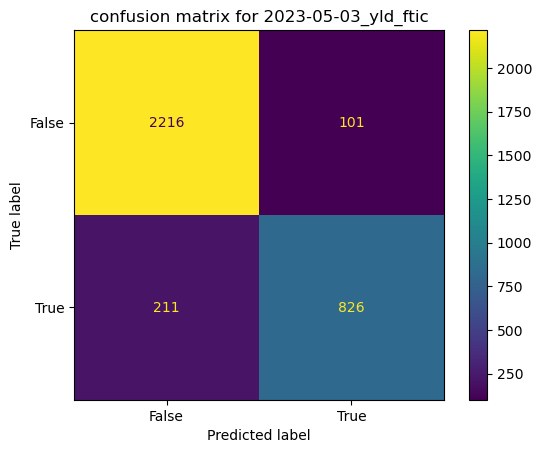

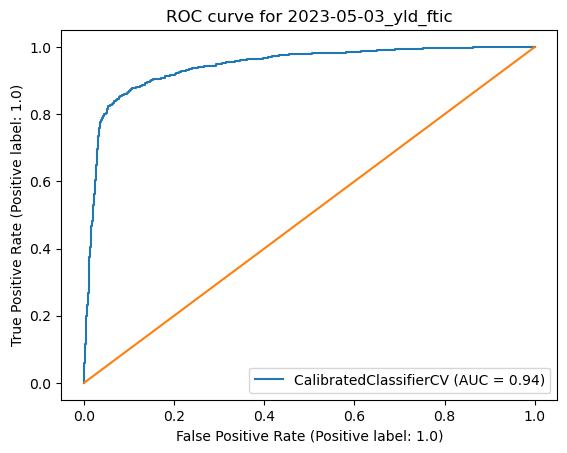

re-refit best 2023-05-03_yld_ftic on all data with rigorous calibration
computing shap values


count      mean       std       min       25%       50%   
oriented:no        3354.0  1.392430  0.730841  0.557363  0.952870  0.994115  \
ssb_last_accessed  3354.0  0.770236  0.214666  0.277351  0.611754  0.758196   
oriented:yes       3354.0  0.419835  0.216121  0.104683  0.275512  0.329097   
eager              3354.0  0.266650  0.314295  0.000043  0.107532  0.198753   
distance           3354.0  0.244285  0.251715  0.000006  0.071805  0.165335   
legacy             3354.0  0.164038  0.136526  0.003717  0.083222  0.116981   
schlship_app       3354.0  0.185143  0.179477  0.001754  0.086505  0.115531   
hs_pctl            3354.0  0.134958  0.108176  0.000073  0.056414  0.108337   
sat10_total_score  3354.0  0.094679  0.070724  0.000067  0.044992  0.080950   
fafsa_app          3354.0  0.077826  0.043761  0.007375  0.044618  0.067619   

                        75%       max  
oriented:no        2.192443  2.990302  
ssb_last_accessed  0.866888  1.693702  
oriented:yes       0.565609  1.091898  
eager              0.271428  3.024732  
distance           0.356610  1.673422  
legacy             0.174254  1.018855  
schlship_app       0.190285  1.822471  
hs_pctl            0.186266  0.939272  
sat10_total_score  0.126265  0.629474  
fafsa_app          0.098847  0.443095

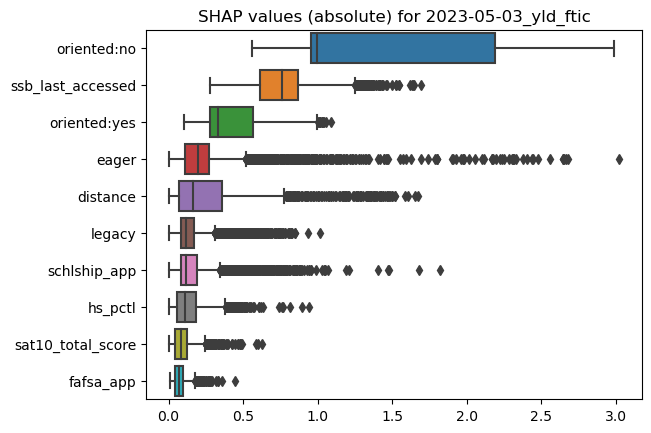

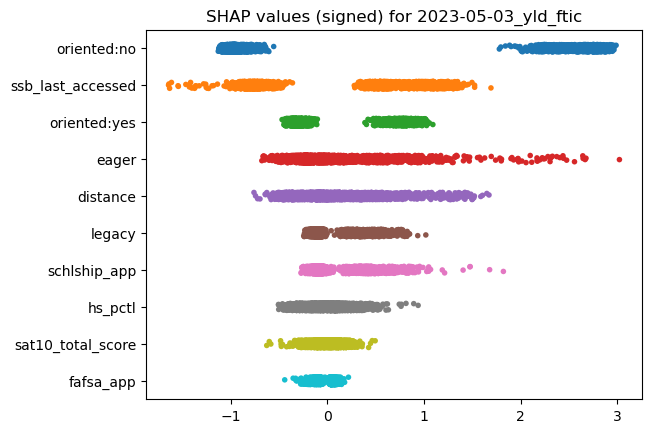

building modl/2023-05-03_yld_trf.model
tuning 2023-05-03_yld_trf with minimal calibration
best cross-validated 2023-05-03_yld_trf neg_log_loss=-0.631 with hyperparameters: {'estimator__learn__learning_rate': 0.2231111111111111, 'estimator__learn__l2_regularization': 1.0707070707070707}
re-training best 2023-05-03_yld_trf for performance report
              precision    recall  f1-score   support

       False       0.68      0.27      0.39       174
        True       0.66      0.92      0.77       271

    accuracy                           0.67       445
   macro avg       0.67      0.59      0.58       445
weighted avg       0.67      0.67      0.62       445



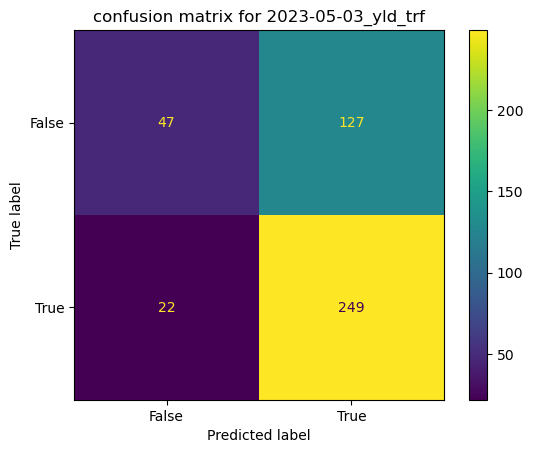

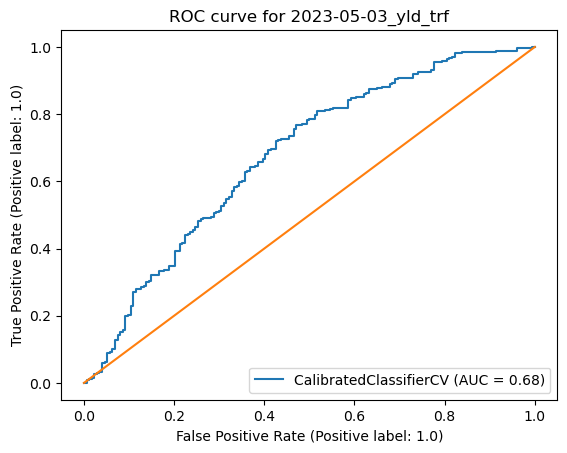

re-refit best 2023-05-03_yld_trf on all data with rigorous calibration
computing shap values


count      mean       std       min       25%       50%   
ssb_last_accessed   445.0  0.988113  0.768967  0.000439  0.564796  0.696166  \
eager               445.0  0.590903  0.513985  0.001821  0.182741  0.463402   
distance            445.0  0.445282  0.311939  0.005243  0.187769  0.391881   
sat10_total_score   445.0  0.426996  0.361276  0.001731  0.158371  0.367248   
age                 445.0  0.378831  0.256678  0.000242  0.171160  0.349982   
hs_pctl             445.0  0.421272  0.353926  0.000211  0.165190  0.334280   
act_new_comp_score  445.0  0.315568  0.249259  0.003770  0.129723  0.251139   
schlship_app        445.0  0.264665  0.183583  0.000596  0.140263  0.217571   
disb_req_complete   445.0  0.220407  0.138198  0.000657  0.102143  0.213988   
gap                 445.0  0.150384  0.122804  0.000092  0.053128  0.120294   

                         75%       max  
ssb_last_accessed   0.898300  3.684527  
eager               0.829544  2.899087  
distance            0.645273  1.637616  
sat10_total_score   0.572444  2.803508  
age                 0.525406  1.400891  
hs_pctl             0.574678  2.091551  
act_new_comp_score  0.453065  1.511627  
schlship_app        0.337088  0.961816  
disb_req_complete   0.310086  0.608072  
gap                 0.214315  0.639136

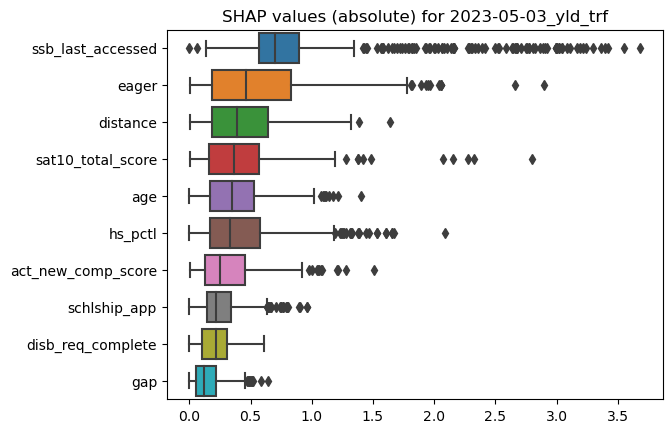

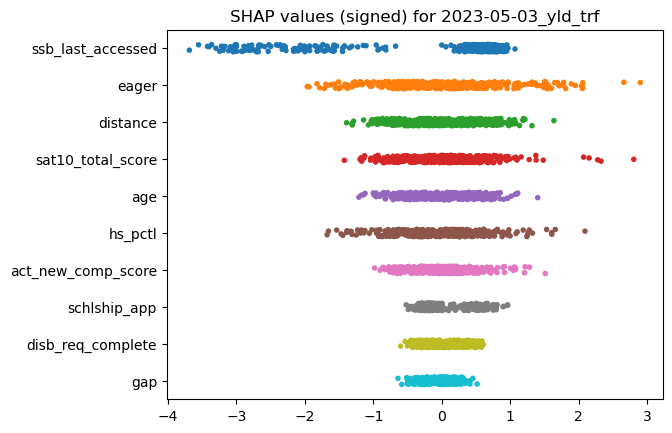

building modl/2023-05-03_yld_rtn.model
tuning 2023-05-03_yld_rtn with minimal calibration
best cross-validated 2023-05-03_yld_rtn neg_log_loss=-0.607 with hyperparameters: {'estimator__learn__learning_rate': 0.4452222222222222, 'estimator__learn__l2_regularization': 1.676767676767677}
re-training best 2023-05-03_yld_rtn for performance report
              precision    recall  f1-score   support

       False       1.00      0.06      0.11        17
        True       0.71      1.00      0.83        40

    accuracy                           0.72        57
   macro avg       0.86      0.53      0.47        57
weighted avg       0.80      0.72      0.62        57



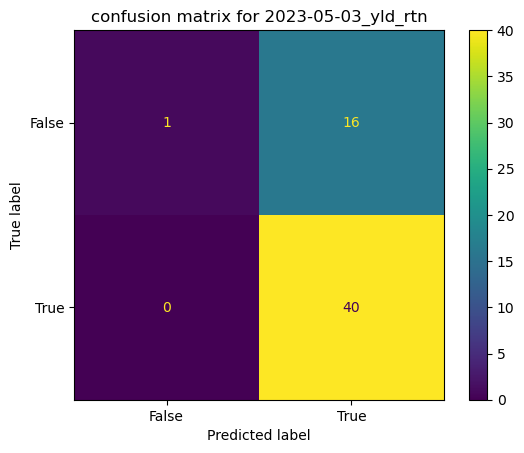

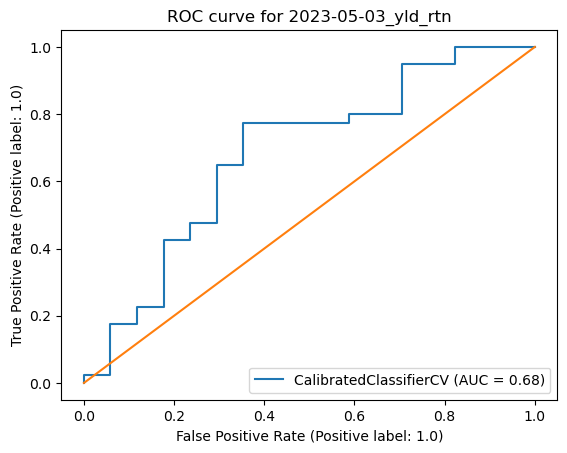

re-refit best 2023-05-03_yld_rtn on all data with rigorous calibration
computing shap values


count      mean       std       min   
act_new_comp_score                57.0  1.120576  0.786126  0.046233  \
eager                             57.0  0.872595  0.463555  0.152409   
distance                          57.0  0.862799  0.722090  0.009291   
main_campus                       57.0  0.645093  0.241991  0.260781   
disb_req_complete                 57.0  0.520664  0.224796  0.166865   
sat10_total_score                 57.0  0.492178  0.470115  0.001305   
hs_pctl                           57.0  0.346849  0.309216  0.001172   
admt_code_descr:readmit_student   57.0  0.352365  0.250223  0.014645   
age                               57.0  0.335840  0.272950  0.016286   
race:black                        57.0  0.325780  0.348816  0.097522   

                                      25%       50%       75%       max  
act_new_comp_score               0.411382  0.946518  1.566224  3.121117  
eager                            0.512668  0.772131  1.184806  1.864908  
distance                         0.181951  0.614237  1.322418  2.486634  
main_campus                      0.461591  0.613594  0.770348  1.313080  
disb_req_complete                0.251081  0.575075  0.707870  0.919951  
sat10_total_score                0.194198  0.346723  0.549547  2.191991  
hs_pctl                          0.123096  0.310538  0.443707  1.320646  
admt_code_descr:readmit_student  0.212650  0.292642  0.401662  0.991376  
age                              0.120138  0.268018  0.514183  1.002273  
race:black                       0.163949  0.197728  0.281419  1.639518

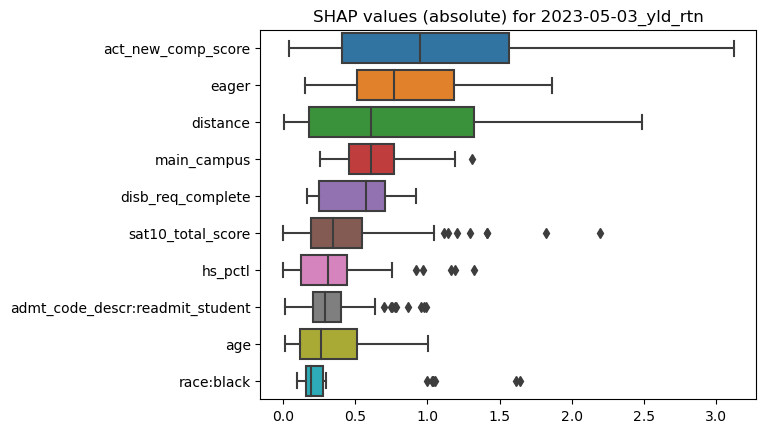

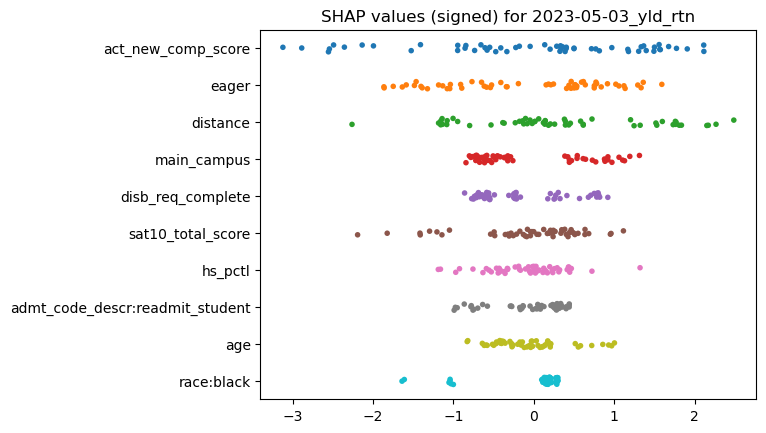

building modl/2023-05-03_engl1301_all.model
tuning 2023-05-03_engl1301_all with minimal calibration
best cross-validated 2023-05-03_engl1301_all neg_log_loss=-0.509 with hyperparameters: {'estimator__learn__learning_rate': 0.2231111111111111, 'estimator__learn__l2_regularization': 1.0707070707070707}
re-training best 2023-05-03_engl1301_all for performance report
              precision    recall  f1-score   support

       False       0.74      0.85      0.79       918
        True       0.54      0.38      0.45       431

    accuracy                           0.70      1349
   macro avg       0.64      0.61      0.62      1349
weighted avg       0.68      0.70      0.68      1349



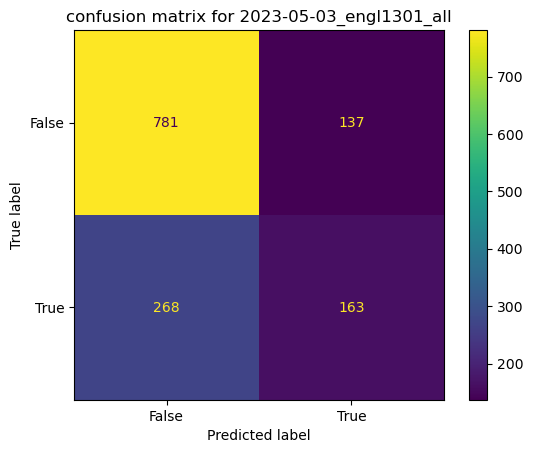

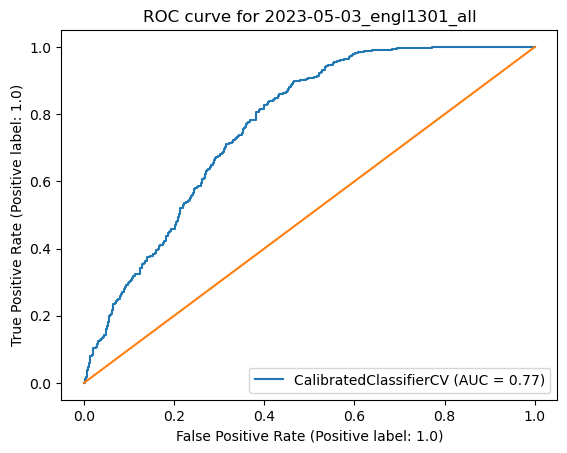

re-refit best 2023-05-03_engl1301_all on all data with rigorous calibration
computing shap values


count      mean       std       min       25%       50%   
student_type:ftic   1349.0  1.024980  0.713092  0.353727  0.616791  0.695844  \
hs_pctl             1349.0  0.483396  0.447643  0.000190  0.152701  0.337332   
main_campus         1349.0  0.492743  0.660303  0.210777  0.280482  0.291761   
distance            1349.0  0.284347  0.222914  0.000205  0.109479  0.231285   
eager               1349.0  0.262611  0.243998  0.000680  0.096078  0.200879   
sat10_total_score   1349.0  0.269138  0.269492  0.000029  0.086536  0.192462   
writing             1349.0  0.217081  0.123296  0.003857  0.145194  0.190613   
act_new_comp_score  1349.0  0.230169  0.235657  0.000449  0.081260  0.173648   
oriented:yes        1349.0  0.099214  0.064353  0.000195  0.055122  0.089877   
student_type:trf    1349.0  0.124853  0.126018  0.008358  0.059985  0.077903   

                         75%       max  
student_type:ftic   0.792714  2.698450  
hs_pctl             0.710702  2.861426  
main_campus         0.302495  3.118632  
distance            0.402525  1.309079  
eager               0.346905  1.777117  
sat10_total_score   0.356699  2.193296  
writing             0.246781  0.815060  
act_new_comp_score  0.305681  2.133787  
oriented:yes        0.127915  0.451461  
student_type:trf    0.112275  0.709572

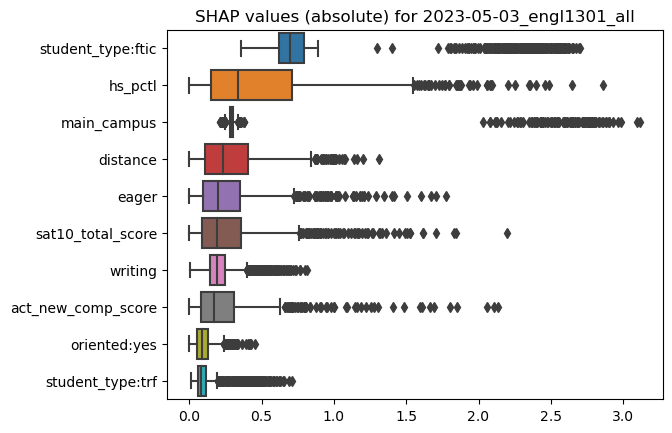

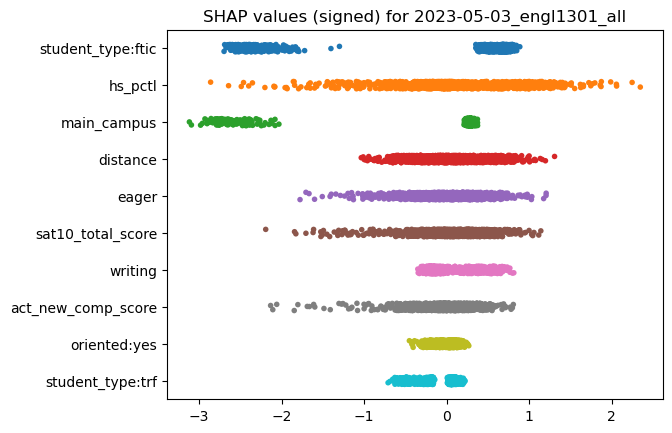

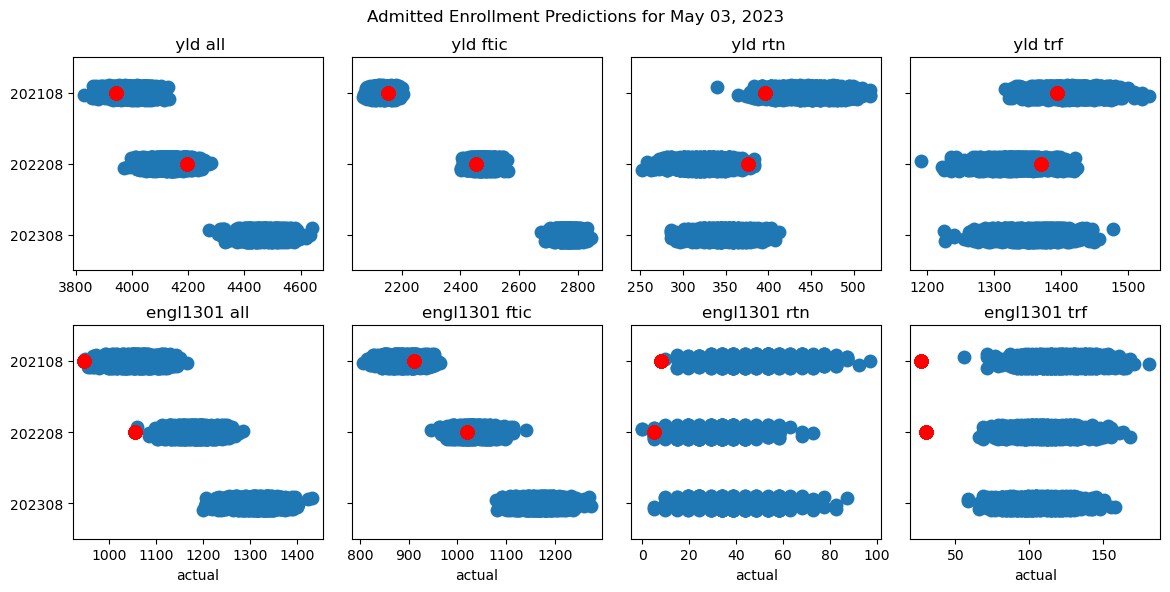

In [3]:
self = EnrollmentPredictor(
    attrs = ['student_type'],
    feats = [
        # process
        'fafsa_app','schlship_app','finaid_accepted','declined_schlrship','disb_req_complete','ssb_last_accessed','oriented','verified','eager',
        # tests
        'math','reading','writing','act_new_comp_score','sat10_total_score','hs_pctl','gap',
        # personal
        'student_type','admt_code_descr','main_campus','resident','distance','age','legacy','hispanic','race','gender',
    ],
    targs = ['yld', 'engl1301',
             # 'engl1302', 'govt2305', 'govt2306', 'hist1301', 'hist1302',
             # 'comm1311', 'comm1315', 'phil1301', 'arts1301', 'musi1306',
             # 'chem1111', 'chem1112', 'chem1311', 'chem1312', 'chem1407',
             # 'math1314', 'math1342', 'math2412', 'math2413',
             # 'phys1401', 'phys1402', 'phys2425', 'phys2426',
    ],
    random_state=42,
    cv__folds=5,
    tune__n_iter=20,
    boot__n_samples=1000,
    impute__n_neighbors=15,
    # shap__n_means=10,
    # shap__n_samples=100,
    test_size=0.25,
    refresh=[
        # 'courses',
        # 'distances',
        # 'flags',
        # 'bunting',
        # 'final',
        # 'multipliers',
        # 'F',
        # 'y',
        # 'X',
        # 'X_imp',
        'model',
        # 'proba',
        # 'samples',
        # 'predictions',
        # 'intervals',
    ],
    # flags_date='2023-04-17',
    # flags_date='2023-04-26',
    flags_date='2023-05-03',
    do_shap=True,
    # report_performance=False,
)

if self.do_shap:
    import shap

# print(self.refresh)
# C = self.get_courses()
# D = self.get_distances()
# B = self.get_bunting()
# self.completeness()
# F = self.get_final()
# M = self.get_multipliers()
# self.get_modeling_set()#True)
# self.get_models()
# P = self.get_proba()
# S = self.get_samples()
# P = self.get_predictions()
# I = self.get_intervals()
self.plot_predictions()
# self.run()

# model = self.models['yld']['trf']
# self.plot_shap(model)


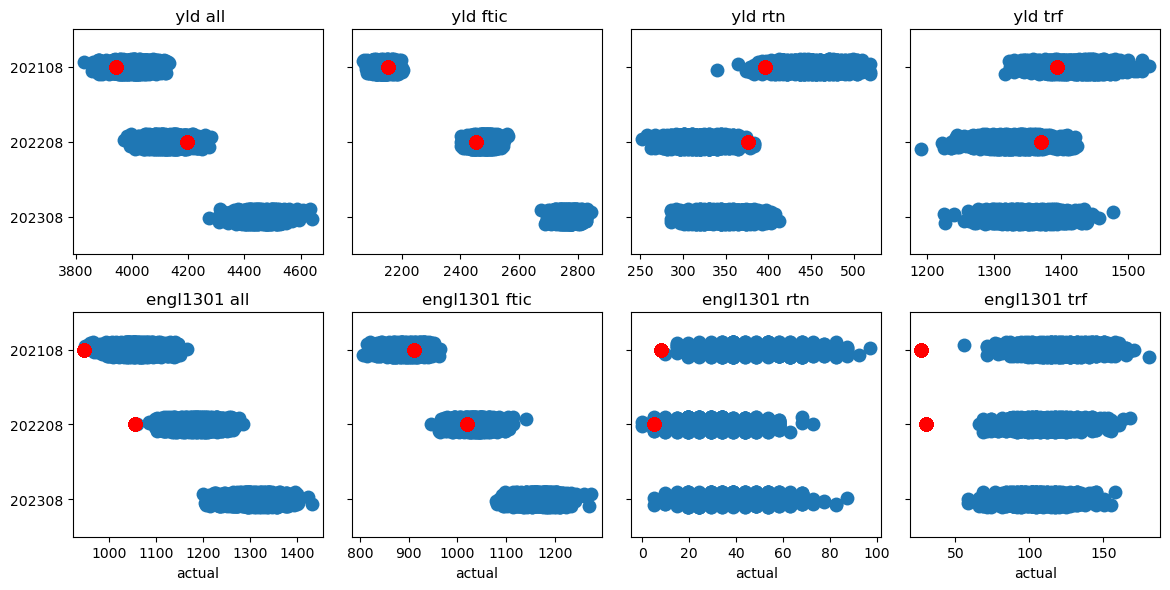

In [25]:
idx = ['course', 'term_code', 'student_type']
Z = (P.reset_index()
     .assign(name=lambda x: x['course']+'_'+x['student_type'])
     # .assign(term_code=lambda x: x['term_code'].astype('string'))
).prep()
order = np.unique(Z['term_code'])

# fig = sns.FacetGrid(Z, col='student_type', row='course', sharex=False, despine=False, legend_out=True)
fig = sns.FacetGrid(Z, col='name', col_wrap=4, sharex=False, despine=False, legend_out=True)
# fig.map(sns.boxplot  ,'predict', 'term_code', orient='h', order=order)#, hue=Z['term_code'], palette='viridis')
fig.map(sns.stripplot,'predict', 'term_code', orient='h', order=order, size=10)#, hue=Z['term_code'], palette='viridis')

# fig.map(sns.stripplot,'predict', 'term_code', orient='h', order=order)#, hue=Z['term_code'], palette='viridis')
fig.map(sns.stripplot, 'actual', 'term_code', orient='h', order=order, size=10, color='red', jitter=False)

for ax in fig.axes.flatten():
    ax.set_title(ax.get_title().split(' = ')[-1].replace('_', ' '))
fig.set(ylabel=None)

In [75]:
Z

course term_code student_type      predict  actual          name   
0          _yld    202108          all  3988.750968    3945      _yld_all  \
1          _yld    202108          all   4083.29847    3945      _yld_all   
...         ...       ...          ...          ...     ...           ...   
23998  engl1301    202308          trf   122.232054    <NA>  engl1301_trf   
23999  engl1301    202308          trf   122.232054    <NA>  engl1301_trf   

       sizer  
0         10  
1         10  
...      ...  
23998     10  
23999     10  

[24000 rows x 7 columns]

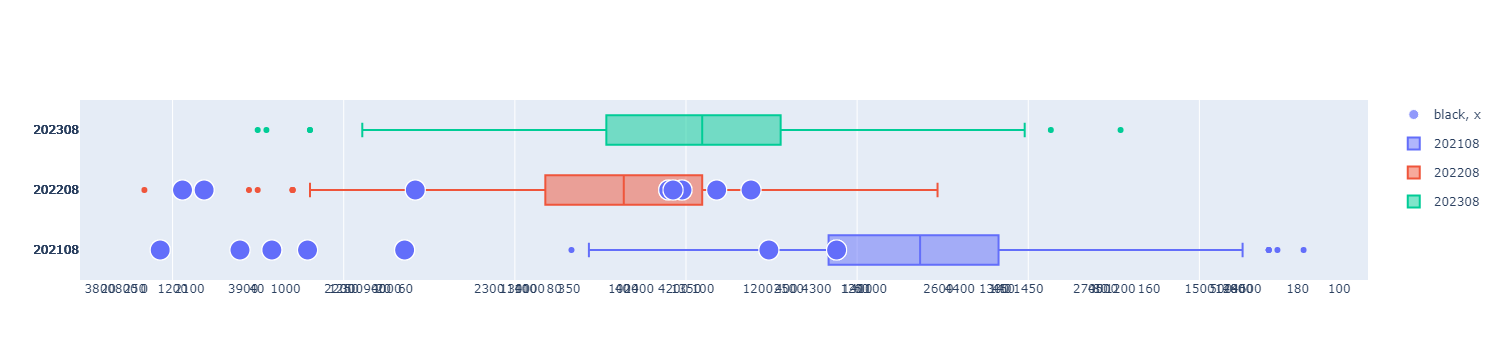

In [99]:
import plotly.express as px, plotly.graph_objects as go
Z = (P.reset_index()
     .assign(name=lambda x: x['course']+'_'+x['student_type'])
     .assign(term_code=lambda x: x['term_code'].astype('string'))
     .assign(size=10)
     .assign(mark='x')
     .assign(color='black')
)

fig1 = px.box(
    Z,
    x="predict",
    y="term_code",
    color="term_code",
    facet_col="name",
    facet_col_wrap=4,
    orientation="h",
    facet_col_spacing=0.01,
    facet_row_spacing=0.1,
    height=800,
)

fig2 = px.scatter(
    Z,
    x="actual",
    y="term_code",
    color="color",
    size="size",
    symbol='mark',
    facet_col="name",
    facet_col_wrap=4,
    orientation="h",
    facet_col_spacing=0.01,
    facet_row_spacing=0.1,
    height=800,
)

for fig in [fig1, fig2]:
    opts = {'title':None, 'mirror':True, 'ticks':'outside', 'showline':True, 'linewidth':2, 'linecolor':'black', 'matches':None}
    fig.update_xaxes(**opts)
    fig.update_yaxes(**opts)
    fig.update_layout(title_text=f'Admitted Enrollment Predictions for {self.flags_date.strftime("%B %d, %Y")}', title_x=0.5)
    fig.for_each_xaxis(lambda xaxis: xaxis.update(showticklabels=True))
    fig.for_each_annotation(lambda a: a.update(text=a.text.split('=')[-1].replace('_',' ').upper()))

fig3 = go.Figure(data=fig2.data + fig1.data)
fig3.show()

In [ ]:
import plotly.graph_objects as go
Z = (P.reset_index()
 .assign(name=lambda x: x['course']+'_'+x['student_type'])
 .assign(term_code=lambda x: x['term_code'].astype('string'))
)

fig = px.box(
    Z,
    x="predict",
    y="term_code",
    color="term_code",
    facet_col="name",
    facet_col_wrap=4,
    orientation="h",
    facet_col_spacing=0.01,
    facet_row_spacing=0.1,
    height=800,
)


fig2 = px.scatter(
    Z,
    x="actual",
    y="term_code",
    # color="black",
    facet_col="name",
    facet_col_wrap=4,
    orientation="h",
    facet_col_spacing=0.01,
    facet_row_spacing=0.1,
    height=800,
)

# fig.add_trace(go.Scatter(
#     x=Z["actual"],
#     y=Z["term_code"],
#     mode='markers',
#     facet_col="name",
#     facet_col_wrap=4,

# ))

# fig.update_traces(width=0.8)
opts = {'title':None, 'mirror':True, 'ticks':'outside', 'showline':True, 'linewidth':2, 'linecolor':'black', 'matches':None}
fig.update_xaxes(**opts)
fig.update_yaxes(**opts)
fig.update_layout(title_text=f'Admitted Enrollment Predictions for {self.flags_date.strftime("%B %d, %Y")}', title_x=0.5)
fig.for_each_xaxis(lambda xaxis: xaxis.update(showticklabels=True))
fig.for_each_annotation(lambda a: a.update(text=a.text.split('=')[-1].replace('_',' ').upper()))
fig.show()

In [ ]:
go.box

In [ ]:
idx = ['course', 'term_code', 'student_type']
Z = (P.reset_index()
 # .assign(name=lambda x: x['course']+'_'+x['student_type'])
     .assign(term_code=lambda x: x['term_code'].astype('string'))
     # .set_index(['course', 'term_code', 'student_type'])
)

# Z=P

# Z = (P.reset_index()
#  .assign(name=lambda x: x['course']+'_'+x['student_type'])
#  .assign(term_code=lambda x: x['term_code'].astype('string'))
# )
# for crs, z in Z.groupby('course'):
#     sns.boxplot(z, x='predict', y='name', hue='term_code', orient='h', dodge=True)
#     plt.show()
# sns.boxplot(P.reset_index().groupby('term_code'), x='predict', orient='h')

# fig = sns.FacetGrid(Z, col='student_type', row='course', sharex=False)
# fig.map(sns.boxplot, 'predict', 'term_code', orient='h')
# fig, ax = plt.subplots()

sns.catplot(
    Z,
    x='predict',
    y='term_code',
    hue='term_code',
    orient='h',
    kind='box',
    row='course',
    col='student_type',
    sharex=False,
    width=0.8,
    # ax=ax,
)

# fig = sns.FacetGrid(Z, col='student_type', row='course', sharex=False)
# fig.map(sns.boxplot, 'predict', 'term_code', orient='h')
# fig, ax = plt.subplots()


sns.catplot(
    Z.dropna().drop_duplicates(subset=idx),
    x='actual',
    y='term_code',
    # hue='term_code',
    size = 50,
    orient='h',
    kind='strip',
    color='red',
    row='course',
    col='student_type',
    sharex=False,
    # width=0.8,
    # ax=ax,
)
# fig.set(ylabel=None)

# plt.show()

In [ ]:
fig = sns.boxplot(Z, x='predict', y='term_code', orient='h', hue='term_code', palette='viridis').legend_.remove()
# fig.set(legend=None)
# fig.legend_.remove()

In [ ]:
sns.boxplot?

In [106]:
sns.FacetGrid?

Init signature:
sns.FacetGrid(
    data,
    *,
    row=None,
    col=None,
    hue=None,
    col_wrap=None,
    sharex=True,
    sharey=True,
    height=3,
    aspect=1,
    palette=None,
    row_order=None,
    col_order=None,
    hue_order=None,
    hue_kws=None,
    dropna=False,
    legend_out=True,
    despine=True,
    margin_titles=False,
    xlim=None,
    ylim=None,
    subplot_kws=None,
    gridspec_kws=None,
)
Docstring:      Multi-plot grid for plotting conditional relationships.
Init docstring:
Initialize the matplotlib figure and FacetGrid object.

This class maps a dataset onto multiple axes arrayed in a grid of rows
and columns that correspond to *levels* of variables in the dataset.
The plots it produces are often called "lattice", "trellis", or
"small-multiple" graphics.

It can also represent levels of a third variable with the ``hue``
parameter, which plots different subsets of data in different colors.
This uses color to resolve elements on a third dimension, but 

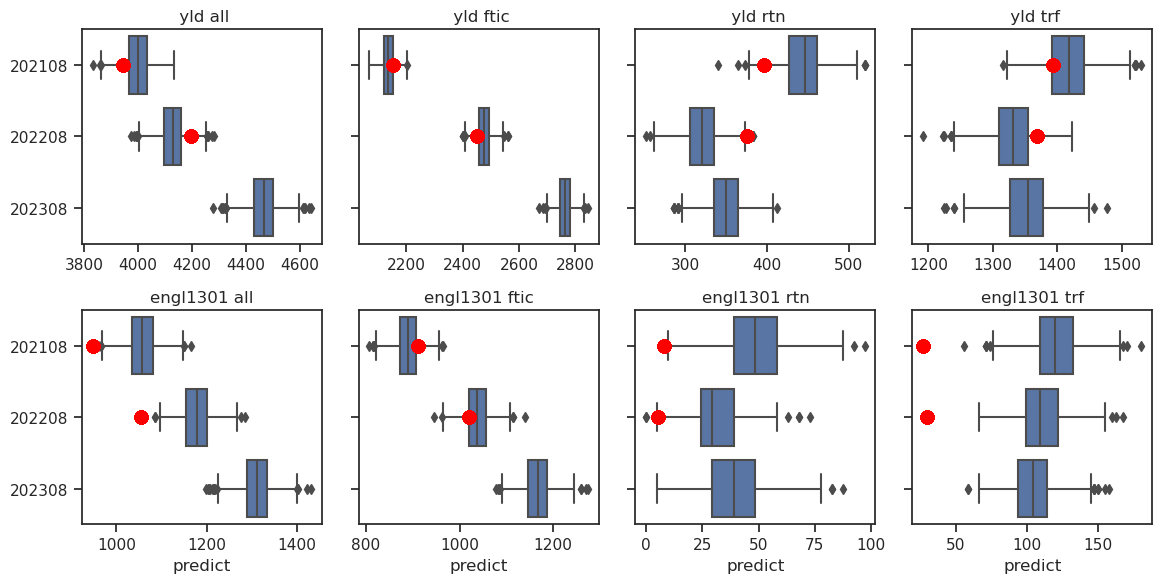

In [128]:
idx = ['course', 'term_code', 'student_type']
Z = (P.reset_index()
     .assign(name=lambda x: x['course']+'_'+x['student_type'])
     .assign(term_code=lambda x: x['term_code'].astype('string'))
)

# fig = sns.FacetGrid(Z, col='student_type', row='course', sharex=False, despine=False, legend_out=True)
fig = sns.FacetGrid(Z, col='name', col_wrap=4, sharex=False, despine=False, legend_out=True)
order = np.unique(Z['term_code'])
fig.map(sns.stripplot, 'actual', 'term_code', orient='h', order=order, size=10, color='red', jitter=False)
fig.map(sns.boxplot  ,'predict', 'term_code', orient='h', order=order)#, hue=Z['term_code'], palette='viridis')

for ax in fig.axes.flatten():
    ax.set_title(ax.get_title().split(' = ')[-1].replace('_', ' '))
fig.set(ylabel=None)
# fig.map(sns.scatterplot, 'actual', 'term_code', sizes=(100,100), color='red', markers='x')#nt='h', order=order, jitter=False)
# fig.map(plt.scatterplot, 'actual', 'term_code', sizes=(100,100), color='red', markers='x')#nt='h', order=order, jitter=False)
# fig.map(plt.scatterplot, 'actual', 'term_code', sizes=(100,100), color='red', markers='x')#nt='h', order=order, jitter=False)
# plt.scatter(data=Z.dropna(), x='actual', y='term_code')

In [123]:
w.get_text().split(' = ')[-1].replace('_', ' ')

' yld all'

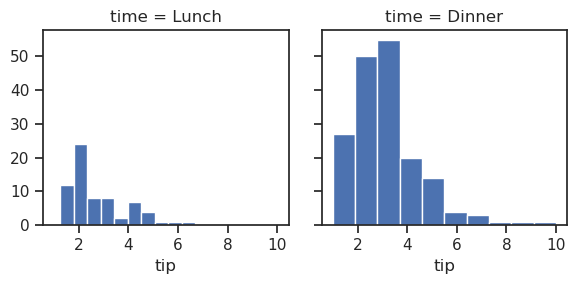

In [101]:
import pandas as pd
import seaborn as sb
from matplotlib import pyplot as plt
sb.set(style='ticks')

df = sb.load_dataset('tips')
g = sb.FacetGrid(df, col = "time", despine=False)
g.map(plt.hist, "tip");

In [ ]:
sns.stripplot?

In [ ]:
mpg['origin'].value_counts()

In [ ]:
from helpers.common_imports import *
import helpers.utilities as ut
import seaborn as sns
sns.set_theme()

mpg = ut.prep(sns.load_dataset("mpg"))
mpg['cylinders'] = mpg['cylinders'].astype('string')
mpg.dtypes
sns.catplot(
    data=mpg, y="cylinders", x="acceleration",# hue="weight",
    orient='h',
    row='origin',
    kind='box',
    # native_scale=True,
    # zorder=1
)
sns.catplot(
    data=mpg, y="cylinders", x="acceleration",# hue="weight",
    orient='h',
    row='origin',
    kind='strip',
    # native_scale=True,
    # zorder=1
)

# sns.catplot(
#     data=mpg, x="cylinders", y="acceleration", col='origin', row='origin',
#     scatter=False, truncate=False, order=2, color=".2",
# )

In [ ]:
sns.catplot?

In [ ]:
Z.dropna().drop(columns

In [ ]:
sns.boxplot?

In [ ]:
sns.FacetGrid?

In [ ]:
fig.map?

In [ ]:
import plotly.graph_objects as go
Z = (P.reset_index()
 .assign(name=lambda x: x['course']+'_'+x['student_type'])
 .assign(term_code=lambda x: x['term_code'].astype('string'))
)

fig = go.Box(
    x=Z["predict"],
    y=Z["term_code"],
    # color="term_code",
    # facet_col="name",
    # facet_col_wrap=4,
    # orientation="h",
    # facet_col_spacing=0.01,
    # facet_row_spacing=0.1,
    # height=800,
)


# fig2 = px.scatter(
#     Z,
#     x="actual",
#     # color="black",
#     facet_col="name",
#     facet_col_wrap=4,
#     orientation="h",
#     facet_col_spacing=0.01,
#     facet_row_spacing=0.1,
#     height=800,
# )

# fig.add_trace(go.Scatter(
#     x=Z["actual"],
#     y=Z["term_code"],
#     mode='markers',
#     facet_col="name",
#     facet_col_wrap=4,

# ))

# fig.update_traces(width=0.8)
# opts = {'title':None, 'mirror':True, 'ticks':'outside', 'showline':True, 'linewidth':2, 'linecolor':'black', 'matches':None}
# fig.update_xaxes(**opts)
# fig.update_yaxes(**opts)
# fig.update_layout(title_text=f'Admitted Enrollment Predictions for {self.flags_date.strftime("%B %d, %Y")}', title_x=0.5)
# fig.for_each_xaxis(lambda xaxis: xaxis.update(showticklabels=True))
# fig.for_each_annotation(lambda a: a.update(text=a.text.split('=')[-1].replace('_',' ').upper()))
# fig.show()
fig.show()

In [ ]:
go.Scatter(
    x=Z["actual"],
    y=Z["term_code"],
    mode='markers',
    facet_col="name",
    facet_col_wrap=4,

)

In [ ]:
px.scatter?

In [ ]:

fig = px.scatter(
    Z,
    x="actual",
    y="term_code",
    # color="black",
    facet_col="name",
    facet_col_wrap=4,
    orientation="h",
    facet_col_spacing=0.01,
    facet_row_spacing=0.1,
    height=800,
)
# fig.update_traces(width=0.8)
opts = {'title':None, 'mirror':True, 'ticks':'outside', 'showline':True, 'linewidth':2, 'linecolor':'black', 'matches':None}
fig.update_xaxes(**opts)
fig.update_yaxes(**opts)
fig.update_layout(title_text=f'Admitted Enrollment Predictions for {self.flags_date.strftime("%B %d, %Y")}', title_x=0.5)
fig.for_each_xaxis(lambda xaxis: xaxis.update(showticklabels=True))
fig.for_each_annotation(lambda a: a.update(text=a.text.split('=')[-1].replace('_',' ').upper()))
fig.show()

In [ ]:
self.flags_date.strftime("%B %d, %Y")

In [ ]:
# fig.update_annotations?
fig.update_yaxes?

In [ ]:
import plotly.express as px
Z = (P.reset_index()
 .assign(name=lambda x: x['course']+'_'+x['student_type'])
 .assign(term_code=lambda x: x['term_code'].astype('string'))
)

fig = px.strip(
    Z.sort_index(ascending=False),
    x="predict",
    # y="student_type",
    y="name",
    color="term_code",
    facet_row="course",
    orientation="h",
    # facet_row_spacing=0.2,
    height=800,
    # boxmode="group",
    # box=True,
    # box=True,
    # points="all",
    # hover_data=df.columns
    # notched = True,
)
# fig.update_traces(width=0.1)
fig.update_yaxes(title=None)
fig.update_annotations(text='')
fig.update_xaxes(matches=None)
fig.for_each_xaxis(lambda xaxis: xaxis.update(showticklabels=True))

fig.show()
    # plt.show()
    # print('hi')


# for crs, z in Z.groupby('course'):
#     fig = px.strip(
#         z,
#         x="predict",
#         y="name",
#         color="term_code",
#         facet_row="student_type",
#         orientation="h",
#         # facet_row_spacing=0.2,
#         height=800,
#         # boxmode="group",
#         # box=True,
#         # box=True,
#         # points="all",
#         # hover_data=df.columns
#         # notched = True,
#     )
#     # fig.update_traces(width=0.9)
#     # fig.update_yaxes(title=None)
#     # fig.update_annotations(text='')
#     # fig.update_xaxes(matches=None)
#     # fig.for_each_xaxis(lambda xaxis: xaxis.update(showticklabels=True))

#     fig.show()
#     # plt.show()
#     # print('hi')

In [ ]:
P

In [ ]:
Z = (P.reset_index()
 .assign(name=lambda x: x['course']+'_'+x['student_type'])
 .assign(term_code=lambda x: x['term_code'].astype('string'))
)
for crs, z in Z.groupby('course'):
    sns.boxplot(z, x='predict', y='name', hue='term_code', orient='h', dodge=True)
    plt.show()
# sns.boxplot(P.reset_index().groupby('term_code'), x='predict', orient='h')

In [ ]:
model = self.models['yld']['rtn']
self.plot_shap(model)
# max_display = 10
# S = model.shap_values.iloc[:,:max_display]
# L = S.abs().apply(np.log1p)  # control fliers using L = ln(1+|S|)

# sns.boxplot(L, orient='h')
# plt.title(f'ln1p SHAP absolute for {model.name}')
# model.shap_box = self.path['shap'] / f'{model.name}_shap_box.png'
# plt.savefig(model.shap_box, bbox_inches='tight')
# plt.show()

# sns.stripplot(L * np.sign(S), orient='h', size=4)
# plt.title(f'ln1p SHAP signed for {model.name}')
# model.shap_dots = self.path['shap'] / f'{model.name}_shap_dots.png'
# plt.savefig(model.shap_dots, bbox_inches='tight')
# plt.show()


In [ ]:

    # def plot_shap(self, model, 
max_display=10
model = self.models['yld']['ftic']
S = model.shap_values#.iloc[:,:max_display]
# L = S.abs().apply(np.log1p)  # control fliers using L = ln(1+|S|)
L = S.abs()

# fig, ax = plt.subplots(2, 1, figsize=(8, 4))#, gridspec_kw=dict(width_ratios=[4, 3]))
sns.stripplot(L * np.sign(S), orient='h', size=4)
plt.title(f'ln1p SHAP signed for {model.name}')
plt.show()
sns.boxplot(L, orient='h')
model.plot = self.path['shap'] / f'{model.name}_shapley.png'
plt.title(f'ln1p SHAP absolute for {model.name}')
plt.savefig(model.plot)
plt.show()
disp(S.abs().describe().T)  # print summary stats


In [ ]:
self.F
niss module

rynewrson and parker

data scientist to use the data being managed

priorities

long term regular comminucation plan + tech writer

azure

In [ ]:
show tabular results
working on visualization
Q: course level or major level
if course - which courses
if major - which majors
